In [10]:
%matplotlib notebook

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

In [13]:
path = "data/FinalEvaluation/MonteCarloControl"
data = np.array([np.load(path + "WithExploringStartsFinal.npy"), 
                 np.load(path + "WithoutExploringStartFinal.npy"), 
                 np.load(path + "OffPolicyFinal.npy")]).T 
                 

df = pd.DataFrame(data, index = [-2,-1,0,1,2], columns = ["MCCwES", "MCCwoES", "MCCoff"])
df

,MCCwES,MCCwoES,MCCoff
-2,19753,26685,52081
-1,466030,456094,444037
0,90342,90852,80827
1,404898,402268,382028
2,18977,24101,41027


In [14]:
def show_chi2(chi2):
    print("Chi2 test statistic: " + str(chi2[0]) + "\np-value: " + str(chi2[1]) + "\ndof: " + str(chi2[2]))

In [15]:
chi2 = chi2_contingency(df)
show_chi2(chi2)

Chi2 test statistic: 29194.70527850419
p-value: 0.0
dof: 8


In [16]:
for col in df.columns:
    new_df = df.drop(columns = col)
    chi2 = chi2_contingency(new_df)
    print(list(map(str, new_df.columns)))
    show_chi2(chi2)
    print()

['MCCwoES', 'MCCoff']
Chi2 test statistic: 13856.35601219465
p-value: 0.0
dof: 4

['MCCwES', 'MCCoff']
Chi2 test statistic: 24376.721831714167
p-value: 0.0
dof: 4

['MCCwES', 'MCCwoES']
Chi2 test statistic: 1761.320489131167
p-value: 0.0
dof: 4



In [17]:
df.iloc[1] = df.iloc[0] + df.iloc[1]
df.iloc[3] = df.iloc[3] + df.iloc[4]
df = df.drop(index = [-2,2])
df

,MCCwES,MCCwoES,MCCoff
-1,485783,482779,496118
0,90342,90852,80827
1,423875,426369,423055


In [18]:
chi2 = chi2_contingency(df)
show_chi2(chi2)

Chi2 test statistic: 944.6831622913356
p-value: 3.466030596461758e-203
dof: 4


In [19]:
for col in df.columns:
    new_df = df.drop(columns = col)
    chi2 = chi2_contingency(new_df)
    print(list(map(str, new_df.columns)))
    show_chi2(chi2)
    print()

['MCCwoES', 'MCCoff']
Chi2 test statistic: 780.0926405105445
p-value: 4.02749886282151e-170
dof: 2

['MCCwES', 'MCCoff']
Chi2 test statistic: 638.4980030265551
p-value: 2.2486418525946887e-139
dof: 2

['MCCwES', 'MCCwoES']
Chi2 test statistic: 18.06798877739703
p-value: 0.00011928506936569074
dof: 2



In [20]:
path = "data/LearningRate/MonteCarloControl"
a1, a2, a3 = np.load(path + "WithExploringStartsLR.npy"), np.load(path + "WithoutExploringStartLR.npy"), np.load(path + "OffPolicyLR.npy")

In [21]:
profits = [np.array(list(map(lambda x: x.dot([-2,-1,0,1,2]), a))) for a in [a1, a2, a3]]
rates = [np.array(list(map(lambda x: (x[0] + x[1] - x[3] - x[4]) / sum(x), a))) for a in [a1, a2, a3]]

In [22]:
def poly(ys, d):
    xs = np.arange(len(ys))
    poly = np.polyfit(xs, ys, d)
    exps = np.flip(np.arange(d+1))
    return list(map(lambda x: sum([coef * x ** exp for (coef, exp) in zip(poly, exps)]), xs))

In [23]:
from blackjack import BlackJack

In [24]:
def test_random_policy(epochs = 500_000):
    game = BlackJack()
    actions = ["hit", "stand", "double"]
    rewards = [0] * epochs
    
    for i in range(epochs):
    
        game.start()

        while game.player_hand_sum < 21: # while the player hasn't busted

            action = random.choice(actions)

            if action == "hit":
                game.hit()
            elif action == "stand":
                game.stand() # if we stand, the round ends
                break
            else:
                game.double() # if we double, the round ends because double = hit -> stand
                break

        # store reward
        rewards[i] = game.get_reward()
    return rewards

In [25]:
rewards = np.unique(test_random_policy(), return_counts = True)[1]
rewards

New BlackJack game created


array([132291, 199580,  23215,  99817,  45097], dtype=int64)

In [26]:
random_policy_profit = rewards.dot([-2,-1,0,1,2])
random_policy_rate = (rewards[0] + rewards[1] - rewards[3] - rewards[4]) / sum(rewards)
random_policy_profit, random_policy_rate

(-274151, 0.373914)

<IPython.core.display.Javascript object>


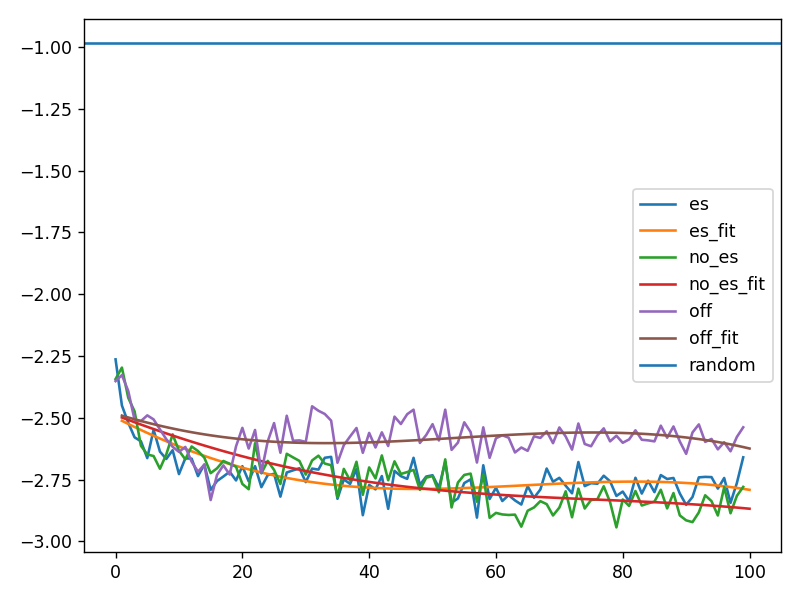

In [27]:
plt.plot(np.log(rates[0][1:]), label = "es")
plt.plot(np.arange(1, len(rates[0])), np.log(poly(rates[0][1:], 3)), label = "es_fit")

plt.plot(np.log(rates[1][1:]), label = "no_es")
plt.plot(np.arange(1, len(rates[1])), np.log(poly(rates[1][1:], 3)), label = "no_es_fit")

plt.plot(np.log(rates[2][1:]), label = "off")
plt.plot(np.arange(1, len(rates[2])), np.log(poly(rates[2][1:], 3)), label = "off_fit")

plt.axhline(np.log(random_policy_rate), label = "random")

plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


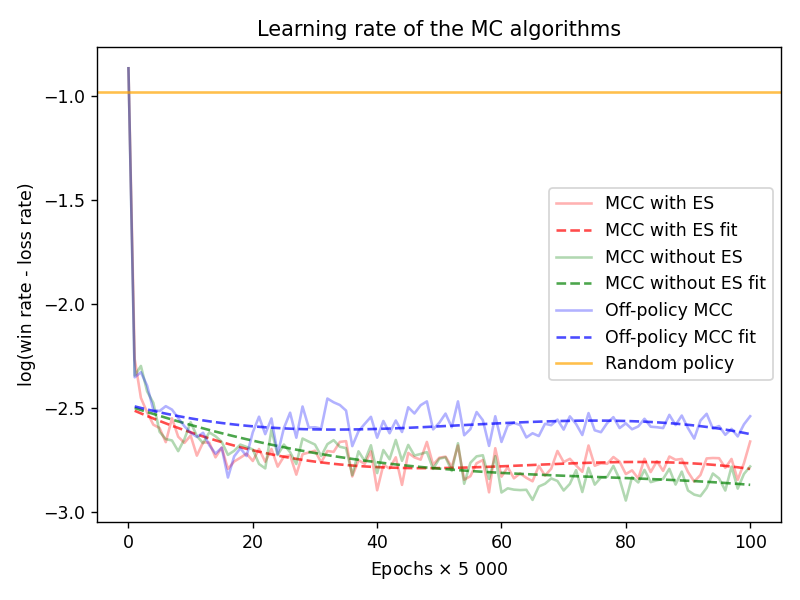

In [53]:
plt.plot(np.log(rates[0]), c = "r", label = "MCC with ES", alpha = .3)
plt.plot(np.arange(1, len(rates[0])), np.log(poly(rates[0][1:], 3)), c = "r", label = "MCC with ES fit", ls = "--", alpha = .7)

plt.plot(np.log(rates[1]), c = "g", label = "MCC without ES", alpha = .3)
plt.plot(np.arange(1, len(rates[1])), np.log(poly(rates[1][1:], 3)), c = "g", label = "MCC without ES fit", ls = "--", alpha = .7)

plt.plot(np.log(rates[2]), c = "b", label = "Off-policy MCC", alpha = .3)
plt.plot(np.arange(1, len(rates[2])), np.log(poly(rates[2][1:], 3)), c = "b", label = "Off-policy MCC fit", ls = "--", alpha = .7)

plt.axhline(np.log(random_policy_rate), label = "Random policy", c = "orange", alpha = .7)

plt.title("Learning rate of the MC algorithms")
plt.ylabel("log(win rate - loss rate)")
plt.xlabel(r"Epochs $\times$ 5 000")

plt.legend()
plt.tight_layout()

plt.show()